[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/mhuertascompany/euclid-school-2025/blob/main/Y1/notebooks/hello_ANN.ipynb)

# Introduction to neural networks

## Rodolphe Cledassou school 2025

> Marc Huertas-Company, Hubert Bretonnière

Illustration of a simple ANN in PyTorch for regression on a 1D dataset with noise.

In [ ]:
# --- EUCLID SCHOOL: LIGHT BOOTSTRAP (no data) -------------------------------
# Detect Colab, (optionally) install minimal deps, (optionally) clone the repo,
# and print device info. It does NOT download any dataset.
# ----------------------------------------------------------------------------
import os, sys, subprocess

# --- Colab detection
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

# --- Settings (edit if needed)
INSTALL_DEPS = True                # set False if you want to skip pip installs on Colab
PIP_PKGS = [
    # Keep small. Colab already has torch + CUDA.
    "datasets==4.*", "transformers==4.*", "timm==1.*", "albumentations==2.*",
    "lightning==2.*", "pytorch-lightning==2.*", "einops==0.*",
    "pyarrow", "seaborn", "umap-learn", "nflows",
    "tensorboard", "tqdm", "safetensors", "opencv-python"
]

# If your notebook relies on repo-relative paths, you can enable this:
CLONE_REPO = False                 # set True only if needed
REPO_URL   = "https://github.com/mhuertascompany/euclid-school-2025.git"
REPO_DIR   = "/content/euclid-school-2025"
SUBDIR     = None                  # e.g., "Y1/notebooks" or "Y2/xyz"

def pip_install(pkgs):
    if not pkgs: return
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--upgrade"] + list(pkgs)
    subprocess.run(cmd, check=True)

if IN_COLAB:
    print("Running on Google Colab ✓")
    if INSTALL_DEPS:
        print("Installing minimal pip deps…")
        pip_install(PIP_PKGS)

    if CLONE_REPO:
        if not os.path.isdir(REPO_DIR):
            print(f"Cloning {REPO_URL} …")
            subprocess.run(["git", "clone", "-q", REPO_URL, REPO_DIR], check=True)
        if SUBDIR:
            os.chdir(os.path.join(REPO_DIR, SUBDIR))
            print("Working directory:", os.getcwd())

    # Device info
    import torch
    print("\nPyTorch:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    try:
        subprocess.run(["nvidia-smi"], check=False)
    except Exception:
        pass
else:
    print("Not running on Colab (no action).")
# ----------------------------------------------------------------------------


In [ ]:
# Native PyTorch setup (replaces TF/Keras)
import math, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid', font='sans-serif', font_scale=1.2, rc={"lines.linewidth": 2})

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(0); np.random.seed(0); random.seed(0)

# Small helpers
def to_tensor(x):
    x = np.asarray(x, dtype=np.float32)
    return torch.from_numpy(x).to(device).view(-1, 1)

@torch.no_grad()
def predict(model, x_np):
    x_t = to_tensor(x_np)
    y_t = model(x_t).squeeze(1)
    return y_t.detach().cpu().numpy()

class History:
    pass

# custom function for training and saving the training history
def train_regressor(model, x_np, y_np, epochs=200, lr=1e-2, bs=None, verbose=False):
    model.to(device).train()
    x_t, y_t = to_tensor(x_np), to_tensor(y_np).squeeze(1)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses = []
    N = x_t.size(0)
    for ep in range(epochs):
        if bs is None:
            # full-batch
            opt.zero_grad()
            pred = model(x_t).squeeze(1)
            loss = loss_fn(pred, y_t)
            loss.backward(); opt.step()
        else:
            # mini-batch
            idx = torch.randperm(N)
            for s in range(0, N, bs):
                b = idx[s:s+bs]
                xb, yb = x_t[b], y_t[b]
                opt.zero_grad()
                pred = model(xb).squeeze(1)
                loss = loss_fn(pred, yb)
                loss.backward(); opt.step()
        losses.append(loss.item())
        if verbose and (ep+1) % max(1, epochs//10) == 0:
            print(f"epoch {ep+1:4d}  mse={losses[-1]:.4f}")
    h = History(); h.epoch = list(range(epochs)); h.history = {"loss": losses}
    return h

Using device: mps


## Let's first generate some data...

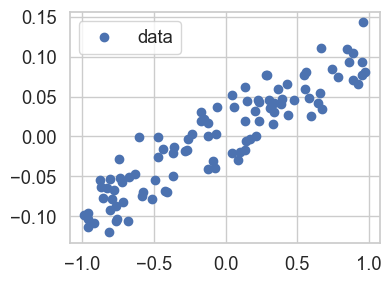

In [2]:
# Generate simple linear-ish data
x = np.random.uniform(-1, 1, 100)
y = 0.1 * x + np.random.normal(0, 0.025, 100)
plt.figure(figsize=(4,3)); plt.scatter(x, y, label="data"); plt.legend(); plt.show()

## The standard way to deal with this, is through linear regression

polyfit degree-1 coefficients [slope, intercept]: [0.09921169 0.00476546]


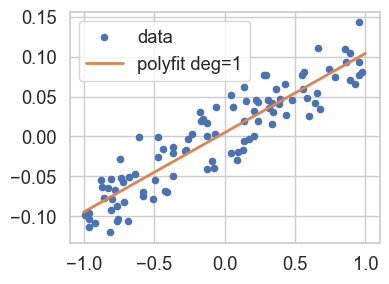

In [3]:
# Linear regression via numpy (degree 1 polyfit) + visualization
res = np.polyfit(x, y, 1)
print("polyfit degree-1 coefficients [slope, intercept]:", res)

x_plot = np.linspace(-1, 1, 400)
y_poly = np.polyval(res, x_plot)

plt.figure(figsize=(4,3))
plt.scatter(x, y, label="data", s=20)
plt.plot(x_plot, y_poly, label="polyfit deg=1", color="C1")
plt.legend(); plt.show()

## Now, let's try to write the linear regression in a different way (more complicated way)

The Dense command here, onnly says that the input is multiplied by a parameter $w$. We are effectively writing a simple model for our data: $y = w.a+b$, where $w$ is unknown.
![alt](images/linearANN_01.png)


We can visualize the model we just created.

In [4]:
# Define a *linear* neural net: y = W x + b
ann = nn.Linear(1, 1).to(device)
print(ann)

Linear(in_features=1, out_features=1, bias=True)


### We then compile

In [5]:
# In PyTorch, "compile" = choose loss + optimizer (no separate compile() step)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=1e-2)
print("Criterion:", criterion, "| Optimizer:", optimizer)

Criterion: MSELoss() | Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


We are simply tht we want to minimize the mean square error (mse) between input and output. We call this the "loss function". So we are looking for the value of $w$ that minimizes the following expression: $$\sum_i(y_i-w.x_i)^2$$

### And fit the model ...

In [7]:
# Train the linear model
history = train_regressor(ann, x, y, epochs=200, lr=1e-2, bs=None, verbose=True)

epoch   20  mse=0.0006
epoch   40  mse=0.0006
epoch   60  mse=0.0006
epoch   80  mse=0.0006
epoch  100  mse=0.0006
epoch  120  mse=0.0006
epoch  140  mse=0.0006
epoch  160  mse=0.0006
epoch  180  mse=0.0006
epoch  200  mse=0.0006


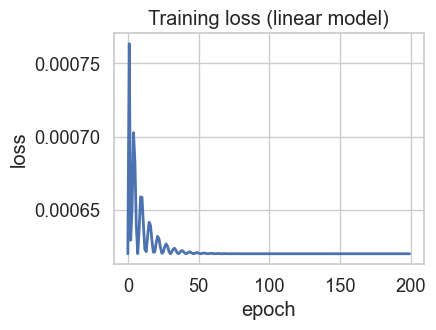

In [8]:
# Plot training loss (Keras-like history object)
plt.figure(figsize=(4,3))
plt.plot(history.epoch, history.history["loss"])
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training loss (linear model)"); plt.show()

### Let's see what we got here...

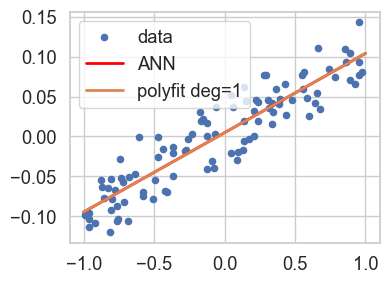

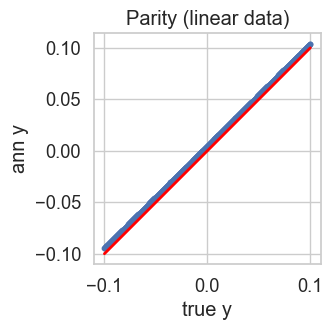

In [9]:
# Show learned line vs data & polyfit
y_ann = predict(ann, x_plot)

plt.figure(figsize=(4,3))
plt.scatter(x, y, label="data", s=20)
plt.plot(x_plot, y_ann, color="red", label="ANN")
plt.plot(x_plot, np.polyval(res, x_plot), label="polyfit deg=1", color="C1")
plt.legend(); plt.show()

# Parity plot (model vs ANN) inside the training range
model_true = lambda u: 0.1 * u
y_true = model_true(x_plot)
plt.figure(figsize=(4,3))
plt.scatter(y_true, y_ann, s=10)
m = [y_true.min(), y_true.max()]
plt.plot(m, m, color="red"); plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("true y"); plt.ylabel("ann y"); plt.title("Parity (linear data)")
plt.show()

We have performed a linear regression with and artifical neural network ! So, yes, linear regression IS also Machine Learning...

### Why is this useful ?

Let's suppose we have a more complex dataset...

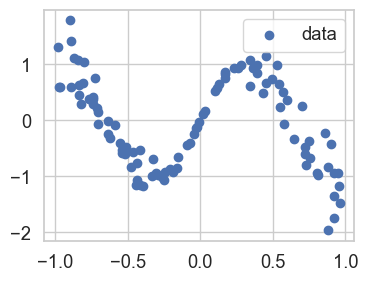

In [10]:
# Generate a more complex dataset and visualize it
x = np.random.uniform(-1, 1, 100)
model_true = lambda u: 0.1 * u + np.sin(5 * u)
y = model_true(x) + np.random.normal(0, 0.45 * np.abs(x), 100)

plt.figure(figsize=(4,3))
plt.scatter(x, y, label="data")
plt.legend(); plt.show()

x_plot = np.linspace(-1, 1, 400)

## We can try again simple polynomial regression with increasing degrees

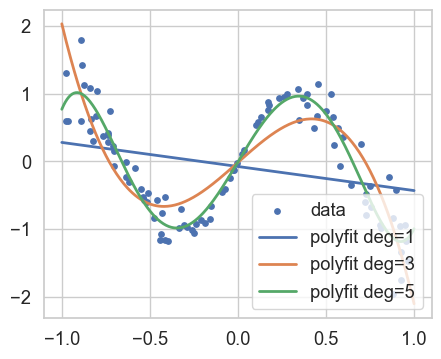

In [15]:
# Polynomial regression baselines (deg=1,3,5)
poly = [(deg, np.polyfit(x, y, deg)) for deg in [1, 3, 5]]

plt.figure(figsize=(5,4))
plt.scatter(x, y, label="data", s=15)
for deg, coeff in poly:
    plt.plot(x_plot, np.polyval(coeff, x_plot), label=f"polyfit deg={deg}")
plt.legend(); plt.show()

# Let's go back to our network...

In [13]:
# Linear ANN (no hidden layer) on complex data
ann_lin = nn.Linear(1, 1).to(device)
hist_lin = train_regressor(ann_lin, x, y, epochs=400, lr=1e-2, bs=None, verbose=True)

epoch   40  mse=0.6017
epoch   80  mse=0.6009
epoch  120  mse=0.6009
epoch  160  mse=0.6009
epoch  200  mse=0.6009
epoch  240  mse=0.6009
epoch  280  mse=0.6009
epoch  320  mse=0.6009
epoch  360  mse=0.6009
epoch  400  mse=0.6009


If I do not change anything, I will obtain the same result. My model is simply linear...

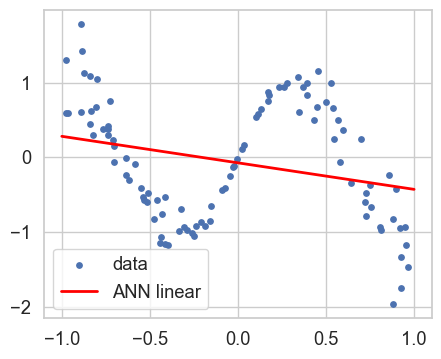

In [14]:
# Visualize linear ANN predictions
y_lin = predict(ann_lin, x_plot)
plt.figure(figsize=(5,4))
plt.scatter(x, y, label="data", s=15)
plt.plot(x_plot, y_lin, color="red", label="ANN linear")
plt.legend(); plt.show()

## and add a bit of non-linearity ...

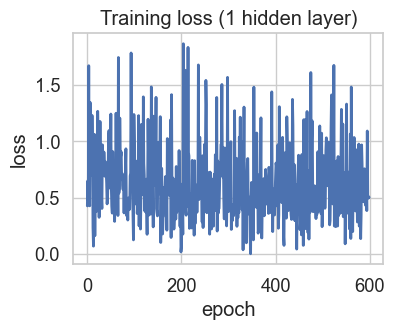

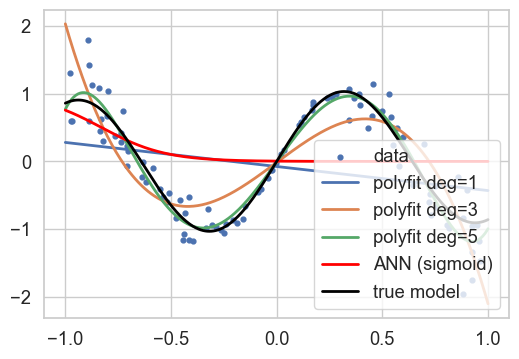

In [ ]:
# Add a bit of non-linearity: 1 hidden layer
ann_shallow = nn.Sequential(
    nn.Linear(1, 1), nn.Sigmoid(),
).to(device)

hist_shallow = train_regressor(ann_shallow, x, y, epochs=600, lr=1e-2, bs=32, verbose=True)

# Loss curve
plt.figure(figsize=(4,3))
plt.plot(hist_shallow.epoch, hist_shallow.history["loss"])
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training loss (1 hidden layer)"); plt.show()

# Predictions vs data and polyfits
y_shallow = predict(ann_shallow, x_plot)
plt.figure(figsize=(6,4))
plt.scatter(x, y, label="data", s=12)
for deg, coeff in poly:
    plt.plot(x_plot, np.polyval(coeff, x_plot), label=f"polyfit deg={deg}")
plt.plot(x_plot, y_shallow, color="red", label="ANN (sigmoid)")
plt.plot(x_plot, model_true(x_plot), color="black", label="true model")
plt.legend(); plt.show()

The sigmoid function is given by this expression: $$ \frac{1}{1+e^{-x}}$$
So our model is now like this:![alt](images/sigmoidANN_02.png)
This is what we call a perceptron. The non-linear function added after the linear combination is also called the activation function, because "it fires the unit".

Still not great, but there is some potential !?

## We can add another layer

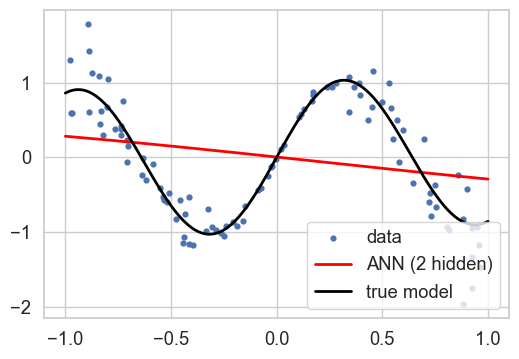

In [ ]:
# Add another layer (slightly deeper)
ann_two = nn.Sequential(
    nn.Linear(1, 1), nn.Sigmoid(),
    nn.Linear(1, 1)
).to(device)

hist_two = train_regressor(ann_two, x, y, epochs=800, lr=1e-2, bs=32, verbose=True)

# Quick look at predictions
y_two = predict(ann_two, x_plot)
plt.figure(figsize=(6,4))
plt.scatter(x, y, label="data", s=12)
plt.plot(x_plot, y_two, color="red", label="ANN (1 hidden)")
plt.plot(x_plot, model_true(x_plot), color="black", label="true model")
plt.legend(); plt.show()

We have added "a layer". Our model is now: $$ y=(\frac{1}{1+e^{-(w_1.x)}}).w_2$$
![alt](images/2layer_ANN.png)

Not fantastic, but you get the idea...You have just created your first ANN for regression!

In fact, it turns out that it exists a mathematical theorem that proves that NNs are optimal approximators:


> _For any continuous function for a hypercube [0,1]d to real numbers, and every positive epsilon, there exists a sigmoid based 1-hidden layer neural network that obtaines at most epsilon error in functional space_  
> Cybenko+89

> _Big enough network can approximate, but not represent any smooth function. the math demonstration implies showing that networs are dense in the space of target functions_

So, the approximation theorem tells me that there exists a NN that can approximate any function. It does not tell me which one: this is the alchemia of ML. It does not tell me how to minimize it either!

## Let's make the model more complex

In [ ]:
# Make the model/data more complex
x = np.random.uniform(-1, 1, 100)
model_true = lambda u: 0.1 * u + np.sin(5 * u)
y = model_true(x) + np.random.normal(0, 0.45 * np.abs(x), 100)

plt.figure(figsize=(4,3))
plt.scatter(x, y, label="data"); plt.legend(); plt.show()

# Polynomial baselines
poly = [(deg, np.polyfit(x, y, deg)) for deg in [1, 3, 5]]
x_plot = np.linspace(-1, 1, 400)

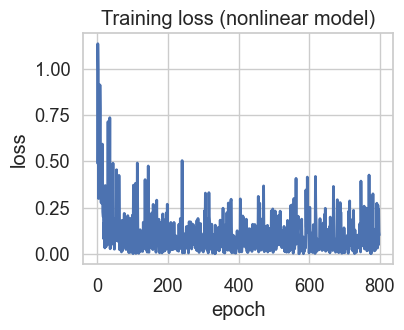

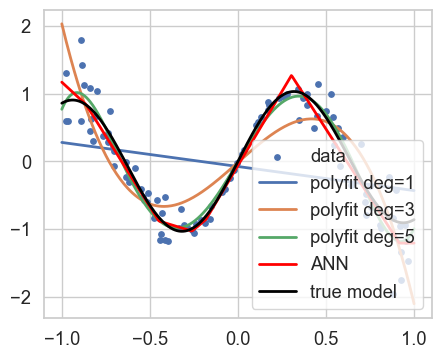

In [21]:
# A slightly deeper neural net to capture nonlinearity
ann = nn.Sequential(
    nn.Linear(1, 10), nn.ReLU(),
    nn.Linear(10, 5), nn.ReLU(),
    nn.Linear(5, 1),
).to(device)

history = train_regressor(ann, x, y, epochs=800, lr=1e-2, bs=16, verbose=True)

# Loss curve
plt.figure(figsize=(4,3))
plt.plot(history.epoch, history.history["loss"]); plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("Training loss (nonlinear model)"); plt.show()

# Predictions vs baselines
y_ann = predict(ann, x_plot)

plt.figure(figsize=(5,4))
plt.scatter(x, y, label="data", s=15)
for deg, coeff in poly:
    plt.plot(x_plot, np.polyval(coeff, x_plot), label=f"polyfit deg={deg}")
plt.plot(x_plot, y_ann, color="red", label="ANN")
plt.plot(x_plot, model_true(x_plot), color="black", label="true model")
plt.legend(); plt.show()

Which is not that far from the real underlying model...

### What if I go beyond my training set?

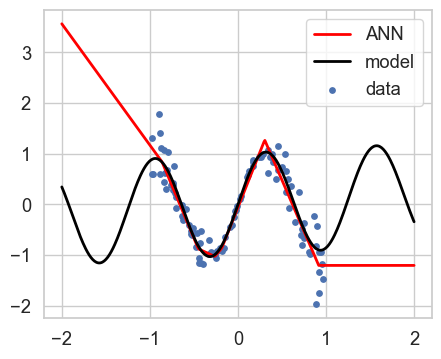

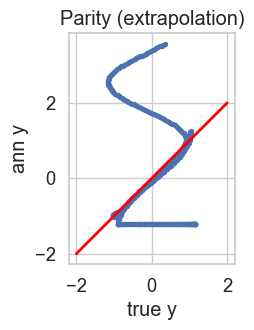

In [22]:
# Extrapolation beyond training range
x_plot_large = np.linspace(-2, 2, 400)
y_ann_large = predict(ann, x_plot_large)
plt.figure(figsize=(5,4))
plt.plot(x_plot_large, y_ann_large, color="red", label="ANN")
plt.plot(x_plot_large, model_true(x_plot_large), label="model", color="black")
plt.scatter(x, y, s=15, label="data"); plt.legend(); plt.show()

# Parity (wide range)
y_predict = y_ann_large
plt.figure(figsize=(4,3))
plt.scatter(model_true(x_plot_large), y_predict, s=8)
plt.plot([-2, 2], [-2, 2], color="red")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("true y"); plt.ylabel("ann y"); plt.title("Parity (extrapolation)")
plt.show()